First, load the audio and take a look at it!

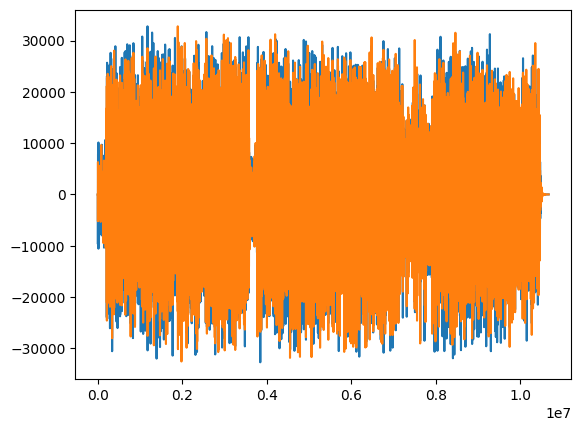

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from Audio.audio_parsing import load_waveform

SONGS_DIRECTORY = "../data"
CHECKPOINTS_DIRECTORY = "./training_checkpoints"

song_name = "song.wav"
song_path = os.path.join(SONGS_DIRECTORY, song_name)
sample_rate, song, audio_channels = load_waveform(song_path)

song_length_seconds = len(song) / sample_rate

fs = 100 #hz
n_samples = int(song_length_seconds * fs)
x_samples = np.linspace(0, len(song) - 1, n_samples).astype(int)

y = song[x_samples]
plt.plot(x_samples, y)
plt.show()

Taking a look at the waveform yields a simple plan to proceed: we should be able to take a series of amplitudes from one section of the song and use it to predict the amplitudes at the next section of the song. This can be done with an RNN. A recurrent neural network that learns on frames of audio, where the input is one frame (i.e., from samples 0 to 100) and the output is the next frame(from 100 to 200). Below, we create these frames.

In [3]:
training_params = {
    
}

In [9]:

def get_frames(song: np.ndarray, frame_size: int = 1024, hop_size: int = 512):
    '''
    The song is the input signal of amplitudes. If the song is not divisible by the frame size, it will be 0-padded.
    The frame_size is the number of samples in each frame.
    The hop_fraction is the fraction of samples between the start of each frame (i.e., how much each frame overlaps the previous one.)
    The array returned is of the shape n_frames, frame_size, n_channels.
    '''
    
    if hop_size == 0:
        hop_size = 1
        
    padded_song_length = len(song) if len(song) % frame_size == 0 else ((len(song) // frame_size) + 1) * frame_size
    pad_width = ((0, padded_song_length - len(song)), (0, 0))
    padded_song = np.pad(song, pad_width, mode='constant', constant_values=0)
        
    last_frame_index = padded_song_length - frame_size
    n_frames = padded_song_length // hop_size
    
    frames = np.zeros(shape=(n_frames, frame_size, padded_song.shape[1]), dtype=np.int16)
    
    for i in range(0, last_frame_index, hop_size):
        frame_index = int(i / hop_size)
        frame = padded_song[i:i + frame_size]
        frames[frame_index] = frame
        
    return frames

def split_frames(frames: np.ndarray):
    '''
    Split the frame set into input and output sets.
    '''
    
    return frames[:-1], frames[1:]

# Show the song length compared to number of frames, make sure values add up perfectly.
frame_size = 1024
hop_fraction = 0.5
hop_size = int(frame_size * hop_fraction)

frames = get_frames(song, frame_size, hop_size)

print(f"Song Shape: {song.shape}\nFrames Shape: {frames.shape}")



Song Shape: (10666876, 2)
Frames Shape: (20834, 1024, 2)


Now that we have an easy function for building these frames, we should create a network to train using them.

In [10]:
import keras

conv1d_layer = keras.layers.Conv1D(filters=8, kernel_size=5, activation='relu', strides=1, padding="causal")

# The LSTM layer for learning the sequence of audio frames
lstm_layer1 = keras.layers.LSTM(8, input_shape=(frame_size, audio_channels), return_sequences=True)
# lstm_layer2 = keras.layers.LSTM(64)

#output an entire audio frame, predicted from the previous frame. The dense layer is used to map the LSTM output to the audio channels.
dense_layer = keras.layers.Dense(audio_channels)

model = keras.models.Sequential([
    conv1d_layer,
                                 
                                 lstm_layer1, 
                                #  lstm_layer2, 
                                 dense_layer
                                 ])

# The optimizer:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# The loss function:
loss = keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Now, we train the model on our sequence of frames from the input song.

In [13]:
input, output = split_frames(frames)

MODEL_NAME = "audio_lstm.weights.h5"
weights_path = os.path.join(CHECKPOINTS_DIRECTORY, MODEL_NAME)

if os.path.exists(weights_path):
    model.load_weights(weights_path)
else:
    model.fit(input, output, epochs=50, batch_size=32, validation_split=0.1)
    model.save_weights(weights_path)


Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.5030 - loss: 90666840.0000 - val_accuracy: 0.5027 - val_loss: 54087940.0000
Epoch 2/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.5040 - loss: 90707440.0000 - val_accuracy: 0.5009 - val_loss: 54021356.0000
Epoch 3/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.5052 - loss: 90878688.0000 - val_accuracy: 0.4945 - val_loss: 53967932.0000
Epoch 4/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.5071 - loss: 91486520.0000 - val_accuracy: 0.5027 - val_loss: 53932536.0000
Epoch 5/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.5021 - loss: 90907856.0000 - val_accuracy: 0.5025 - val_loss: 53891012.0000
Epoch 6/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.5035 - loss: 90613232.0000 - val_accuracy: 0.5028 - val_loss: 53832484.0000
Epoch 7/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.5055 - loss: 90855440.0000 - val_accuracy: 0.5018 - val_loss: 537753

Now that the model is trained and we can easily load its weights from a checkpoint file, we can begin generating audio! For starters, let's try taking the first input frame as a seed. Then, we'll see what the model predicts the next frame should be!

In [12]:

from Audio.audio_parsing import encode_waveform_to_song
from Models.model_utilities import float32_to_int16
from scipy.io import wavfile

def generate_output_frames(seed: np.ndarray, n_frames: int = 1000):
    #when we generate a new frame, that frame is offset by the hop_size. 
    input_sequence = seed.reshape(1, -1, audio_channels)
    
    generated = seed[:hop_size]
    for i in range(n_frames):
        predicted = model.predict(input_sequence)
        
        next_in_sequence = predicted[:, hop_size:]
        generated = np.append(generated, next_in_sequence[0], axis=0)
        
        input_sequence = np.append(input_sequence, next_in_sequence, axis=1)
        
        input_sequence = input_sequence[:, hop_size:]
    
    return generated

seed = input[0]
predicted = generate_output_frames(seed, 1000)
int16_predicted = float32_to_int16(predicted)
wavfile.write("./project2_test.wav", sample_rate, int16_predicted)
print(int16_predicted)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

Unsurprisingly, this doesn't generate the best music. At best, it generates an annoying buzzing noise. According to an article from OpenAI, one-stop solutions seeking to learn all of the many properties of music from waveforms are still being researched. The paper goes on to discuss their moderate success with an encoder-decoder network leveraging VQ-VAE (Vector Quantized Variational Autoencoders). Following this and the research paper on VQ-VAE, Tensorflow Keras documented solutions for their implementation: https://keras.io/examples/generative/vq_vae/

In [1]:
from Models.VQVAETrainer import VQVAETrainer
from Models.model_utilities import get_vqvae

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)


ModuleNotFoundError: No module named 'Models'